# ImageNet Data Exploration
Explore ImageNet dataset, verify stratified sampling, and run LR Finder.


In [2]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from datetime import datetime

from core.config import Config
from core.logger import Logger
from core.data_manager import ImageNetDataManager
from core.model import ModelBuilder
from services.lr_finder import LRFinder

%matplotlib inline


/opt/pytorch/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


2025-10-16 03:08:14,098 - ImageNet_Training - INFO - Loading ImageNet dataset...
2025-10-16 03:08:14,100 - ImageNet_Training - INFO - Train directory: /home/ubuntu/data/imagenet/train
2025-10-16 03:08:14,101 - ImageNet_Training - INFO - Val directory: /home/ubuntu/data/imagenet/val
2025-10-16 03:08:16,985 - ImageNet_Training - INFO - Using full training set: 1281167 samples
2025-10-16 03:08:16,986 - ImageNet_Training - INFO - Validation samples: 50000
2025-10-16 03:08:16,987 - ImageNet_Training - INFO - ImageNet data loaders created successfully!
2025-10-16 03:08:16,988 - ImageNet_Training - INFO -   Train batches: 20019
2025-10-16 03:08:16,988 - ImageNet_Training - INFO -   Val batches: 782


Running LR range test from 1.00e-06 to 5.00e+00


LR: 4.29e+00, Loss: 7.8755: 100%|██████████| 100/100 [02:01<00:00,  1.21s/it]



LR Finder completed. Tested 100 iterations.

Suggested Learning Rate: 2.31e+00
Suggested Max LR (for OneCycleLR): 8.86e-04

Recommendation:
  - Use LR: 2.31e+00 for Adam/AdamW
  - Use max_lr: 8.86e-05 for OneCycleLR


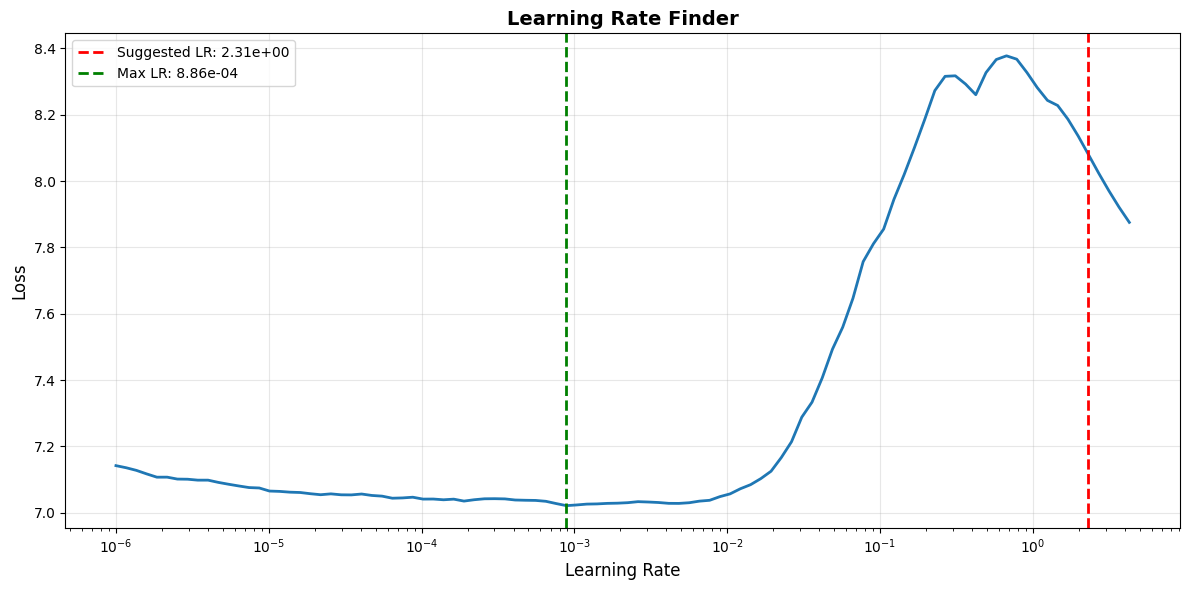

Suggested LR: None
Suggested Max LR: None


In [ ]:
# Config / device
config = Config()
config.data.data_dir = '/home/ubuntu/data/imagenet'   # adjust if needed
config.data.batch_size = 64
logger = Logger(config.logging)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data (train only)
dm = ImageNetDataManager(config.data, logger)
train_loader, _ = dm.load_data()

# Build model
builder = ModelBuilder()
model = builder.build_resnet50(config.model).build().to(device)

# # Optimizer & loss for LR finder
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

#Optimizer SGD and loss BCEWithLogitsLoss for LR finder
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
# _bce_loss = nn.BCEWithLogitsLoss()

# def bce_with_logits_wrapper(outputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
#     """
#     Accepts targets as class indices [B] or multi-hot [B, C].
#     Converts class indices to one-hot floats for BCEWithLogitsLoss.
#     """
#     if targets.dim() == 1 or (targets.dim() == 2 and targets.size(1) == 1):
#         # single-label indices -> convert to one-hot
#         num_classes = outputs.size(1)
#         targets_1hot = torch.zeros(outputs.size(0), num_classes, device=outputs.device, dtype=outputs.dtype)
#         targets_1hot.scatter_(1, targets.view(-1, 1), 1.0)
#         return _bce_loss(outputs, targets_1hot)
#     else:
#         # already one-hot / multi-label
#         return _bce_loss(outputs, targets.float())

# criterion = bce_with_logits_wrapper

# Instantiate and run LR finder
lr_finder = LRFinder(model, optimizer, criterion, device=device)  # adjust args if your LRFinder API differs
learning_rate , losses =lr_finder.range_test(train_loader, start_lr=1e-6, end_lr=5, num_iter=100)  # tune num_iter/end_lr

out_dir = os.getcwd()
filename = f"lr_finder_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
lr_finder.plot(learning_rates=learning_rate ,losses=losses ,save_path=os.path.join(out_dir, filename))  # will show the curve inline

# Try to obtain suggested lr (API may vary)
suggested_lr = getattr(lr_finder, 'get_best_lr', lambda: None)()
suggested_max_lr = getattr(lr_finder, 'suggested_max_lr', lambda: None)()
print(f"Suggested LR: {suggested_lr}")
print(f"Suggested Max LR: {suggested_max_lr}")

# Save plot
# out_dir = os.getcwd()
# filename = f"lr_finder_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
# plt.savefig(os.path.join(out_dir, filename), dpi=150, bbox_inches='tight')
# print(f"Saved LR plot to: {os.path.join(out_dir, filename)}")

# Reset model/optimizer state if LRFinder mutated them
if hasattr(lr_finder, 'reset'):
    lr_finder.reset()

SGD + CrossEntropy: avg_loss=6.9929, time=6.8s
SGD + NLLLoss: avg_loss=7.0124, time=6.8s
SGD + BCEWithLogits: avg_loss=0.0080, time=7.1s
Adam + CrossEntropy: avg_loss=8.5152, time=6.9s
Adam + NLLLoss: avg_loss=8.7074, time=6.8s
Adam + BCEWithLogits: avg_loss=0.0089, time=6.8s
AdamW + CrossEntropy: avg_loss=8.6398, time=6.9s
AdamW + NLLLoss: avg_loss=8.7453, time=6.8s
AdamW + BCEWithLogits: avg_loss=0.0094, time=6.8s
RMSprop + CrossEntropy: avg_loss=20.5753, time=7.0s
RMSprop + NLLLoss: avg_loss=16.5720, time=7.0s
RMSprop + BCEWithLogits: avg_loss=0.0164, time=6.9s

Summary sorted by avg_loss:
optimizer       loss_fn  avg_loss  batches   time_s
      SGD BCEWithLogits  0.008023        5 7.070393
     Adam BCEWithLogits  0.008875        5 6.779126
    AdamW BCEWithLogits  0.009426        5 6.769190
  RMSprop BCEWithLogits  0.016425        5 6.930936
      SGD  CrossEntropy  6.992853        5 6.799892
      SGD       NLLLoss  7.012404        5 6.830922
     Adam  CrossEntropy  8.515244   

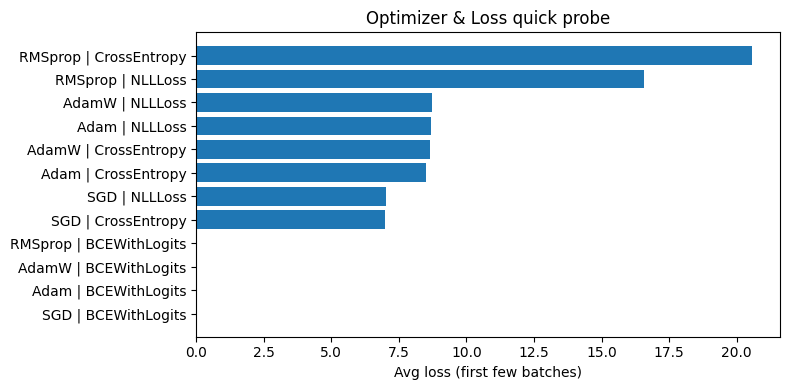

In [3]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn, optim

torch.manual_seed(42)

optimizers = [
    ("SGD", lambda params: optim.SGD(params, lr=1e-3, momentum=0.9, weight_decay=1e-4)),
    ("Adam", lambda params: optim.Adam(params, lr=1e-3, weight_decay=1e-4)),
    ("AdamW", lambda params: optim.AdamW(params, lr=1e-3, weight_decay=1e-4)),
    ("RMSprop", lambda params: optim.RMSprop(params, lr=1e-3, momentum=0.9, weight_decay=1e-4)),
]

loss_fns = [
    ("CrossEntropy", lambda: nn.CrossEntropyLoss(), "cls"),        # expects class indices
    ("NLLLoss", lambda: nn.NLLLoss(), "log_probs"),               # expects log-probs
    ("BCEWithLogits", lambda: nn.BCEWithLogitsLoss(), "onehot"),  # expects one-hot multi-label
]

num_batches = 5  # small probe
results = []

for opt_name, opt_builder in optimizers:
    for loss_name, loss_builder, loss_mode in loss_fns:
        # rebuild model to reset weights
        builder = ModelBuilder()
        model = builder.build_resnet50(config.model).build().to(device)
        model.train()
        optimizer = opt_builder(model.parameters())
        criterion = loss_builder()

        total_loss = 0.0
        t0 = time.time()
        batches = 0

        for i, (images, targets) in enumerate(train_loader):
            if i >= num_batches:
                break
            images = images.to(device); targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)  # raw logits [B, C]

            if loss_mode == "cls":
                loss = criterion(outputs, targets)                       # CrossEntropy
            elif loss_mode == "log_probs":
                logp = F.log_softmax(outputs, dim=1)
                loss = criterion(logp, targets)                         # NLLLoss
            elif loss_mode == "onehot":
                # convert targets to one-hot on-the-fly
                num_classes = outputs.size(1)
                targets_1hot = torch.zeros(outputs.size(0), num_classes, device=device)
                targets_1hot.scatter_(1, targets.view(-1,1), 1.0)
                loss = criterion(outputs, targets_1hot)                 # BCEWithLogitsLoss
            else:
                raise RuntimeError("Unknown loss mode")

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            batches += 1

        elapsed = time.time() - t0
        avg_loss = total_loss / max(1, batches)
        results.append({
            "optimizer": opt_name,
            "loss_fn": loss_name,
            "avg_loss": avg_loss,
            "batches": batches,
            "time_s": elapsed
        })
        print(f"{opt_name} + {loss_name}: avg_loss={avg_loss:.4f}, time={elapsed:.1f}s")

df = pd.DataFrame(results).sort_values(["avg_loss"])
print("\nSummary sorted by avg_loss:")
print(df.to_string(index=False))

plt.figure(figsize=(8,4))
plt.barh(df['optimizer'] + " | " + df['loss_fn'], df['avg_loss'])
plt.xlabel("Avg loss (first few batches)")
plt.title("Optimizer & Loss quick probe")
plt.tight_layout()
plt.show()